# Simulated Annealing Algotithm to sove Travelling Salesman Problem (TSP) in Python From Scratch
---
     By: Mojtaba Zolfaghari
     Last updated on April 28, 2021


### What is Simulated annealing algorithm?

---

    Simulated Annealing is a stochastic global search optimization algorithm.

    This means that it makes use of randomness as part of the search process. This makes the algorithm appropriate for nonlinear objective functions where other local search algorithms do not operate well.

    Like the stochastic hill climbing local search algorithm, it modifies a single solution and searches the relatively local area of the search space until the local optima is located. Unlike the hill climbing algorithm, it may accept worse solutions as the current working solution.

    The likelihood of accepting worse solutions starts high at the beginning of the search and decreases with the progress of the search, giving the algorithm the opportunity to first locate the region for the global optima, escaping local optima, then hill climb to the optima itself.



### What is Travelling salesman problem?

---

    The travelling salesman problem (also called the traveling salesperson problem or TSP) asks the following question: "Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city exactly once and returns to the origin city?" It is an NP-hard problem in combinatorial optimization, important in theoretical computer science and operations research.
    
In the following, we will implement the simulated annealing algorithm on the traveling salesman problem step by step...

## Importing libraries

In [1]:
import random
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

## This class allows to us to generate random list of nodes

In [14]:
class NodeGenerator:
    def __init__(self, width, height, nodesNumber):
        self.width = width
        self.height = height
        self.nodesNumber = nodesNumber

    def generate(self):
        xs = np.random.randint(self.width, size=self.nodesNumber)
        ys = np.random.randint(self.height, size=self.nodesNumber)

        return np.column_stack((xs, ys))

## Create the distance matrix

In [3]:
def vectorToDistMatrix(coords):
    return np.sqrt((np.square(coords[:, np.newaxis] - coords).sum(axis=2)))

## Computes the initial solution (nearest neighbour strategy)

In [4]:
def nearestNeighbourSolution(dist_matrix):
    node = random.randrange(len(dist_matrix))
    result = [node]

    nodes_to_visit = list(range(len(dist_matrix)))
    nodes_to_visit.remove(node)

    while nodes_to_visit:
        nearest_node = min([(dist_matrix[node][j], j) for j in nodes_to_visit], key=lambda x: x[0])
        node = nearest_node[1]
        nodes_to_visit.remove(node)
        result.append(node)

    return result

By using below function we can animate the solution over times
------
      Parameters
     --------------
        hisotry : list
            history of the solutions chosen by the algorith
        points: array_like
            points with the coordinates

In [5]:
def animateTSP(history, points):
    # Approx 1500 frames for animation 
    key_frames_mult = len(history) // 1500

    fig, ax = plt.subplots()

    # Path is a line coming through all the nodes 
    line, = plt.plot([], [], lw=2)

    def init():
        # Initialize node dots on graph 
        x = [points[i][0] for i in history[0]]
        y = [points[i][1] for i in history[0]]
        plt.plot(x, y, 'co')

        # Draw axes slighty bigger  
        extra_x = (max(x) - min(x)) * 0.05
        extra_y = (max(y) - min(y)) * 0.05
        ax.set_xlim(min(x) - extra_x, max(x) + extra_x)
        ax.set_ylim(min(y) - extra_y, max(y) + extra_y)

        # Initialize solution to be empty
        line.set_data([], [])
        return line,

    def update(frame):
        # For every frame update the solution on the graph
        x = [points[i, 0] for i in history[frame] + [history[frame][0]]]
        y = [points[i, 1] for i in history[frame] + [history[frame][0]]]
        line.set_data(x, y)
        return line

    
    # Animate precalulated solutions
    ani = FuncAnimation(fig, update, frames=range(0, len(history), key_frames_mult),
                        init_func=init, interval=3, repeat=False)
    
    # Plot the result
    plt.show()


Simulated annealing implementation
----
            Parameters
            ----------
            coords: array_like
                list of coordinates
            temp: float
                initial temperature
            alpha: float
                rate at which temp decreases
            stopping_temp: float
                temerature at which annealing process terminates
            stopping_iter: int
                interation at which annealing process terminates
  ---
  
  Note: 
       This class use animateTSP function for animating the solution over times.

In [6]:
class SimulatedAnnealing:
    def __init__(self, coords, temp, alpha, stopping_temp, stopping_iter):

        self.coords = coords
        self.sample_size = len(coords)
        self.temp = temp
        self.alpha = alpha
        self.stopping_temp = stopping_temp
        self.stopping_iter = stopping_iter
        self.iteration = 1

        self.dist_matrix = vectorToDistMatrix(coords)
        self.curr_solution = nearestNeighbourSolution(self.dist_matrix)
        self.best_solution = self.curr_solution

        self.solution_history = [self.curr_solution]

        self.curr_weight = self.weight(self.curr_solution)
        self.initial_weight = self.curr_weight
        self.min_weight = self.curr_weight

        self.weight_list = [self.curr_weight]

        print('Intial weight: ', self.curr_weight)

    def weight(self, sol):
        # Calcuate weight
        return sum([self.dist_matrix[i, j] for i, j in zip(sol, sol[1:] + [sol[0]])])

    def acceptance_probability(self, candidate_weight):
        '''
        Acceptance probability as described in:
            https://stackoverflow.com/questions/19757551/basics-of-simulated-annealing-in-python
        '''
        return math.exp(-abs(candidate_weight - self.curr_weight) / self.temp)

    def accept(self, candidate):
        '''
        Accept with probability 1 if candidate solution is better than
        current solution, else accept with probability equal to the
        acceptance_probability()
        '''
        candidate_weight = self.weight(candidate)
        if candidate_weight < self.curr_weight:
            self.curr_weight = candidate_weight
            self.curr_solution = candidate
            if candidate_weight < self.min_weight:
                self.min_weight = candidate_weight
                self.best_solution = candidate

        else:
            if random.random() < self.acceptance_probability(candidate_weight):
                self.curr_weight = candidate_weight
                self.curr_solution = candidate

    def anneal(self):
        '''
        Annealing process with 2-opt
        described here: https://en.wikipedia.org/wiki/2-opt
        '''
        while self.temp >= self.stopping_temp and self.iteration < self.stopping_iter:
            candidate = list(self.curr_solution)
            l = random.randint(2, self.sample_size - 1)
            i = random.randint(0, self.sample_size - l)

            candidate[i: (i + l)] = reversed(candidate[i: (i + l)])

            self.accept(candidate)
            self.temp *= self.alpha
            self.iteration += 1
            self.weight_list.append(self.curr_weight)
            self.solution_history.append(self.curr_solution)

        print('Minimum weight: ', self.min_weight)
        print('Improvement: ',
              round((self.initial_weight - self.min_weight) / (self.initial_weight), 4) * 100, '%')

    def animateSolutions(self):
        animateTSP(self.solution_history, self.coords)

    def plotLearning(self):
        plt.plot([i for i in range(len(self.weight_list))], self.weight_list)
        line_init = plt.axhline(y=self.initial_weight, color='r', linestyle='--')
        line_min = plt.axhline(y=self.min_weight, color='g', linestyle='--')
        plt.legend([line_init, line_min], ['Initial weight', 'Optimized weight'])
        plt.ylabel('Weight')
        plt.xlabel('Iteration')
        plt.show()


# Let's run the code !

### Set the simulated annealing algorithm params

In [7]:
temp = 1000
stopping_temp = 0.00000001
alpha = 0.9995
stopping_iter = 10000000

### Set the dimensions of the grid

In [8]:
size_width = 200
size_height = 200

### Set the number of nodes

In [9]:
population_size = 70

### Generate random list of nodes

In [10]:
nodes = NodeGenerator(size_width, size_height, population_size).generate()

### Run simulated annealing algorithm with 2-opt

In [11]:
sa = SimulatedAnnealing(nodes, temp, alpha, stopping_temp, stopping_iter)
sa.anneal()

Intial weight:  1713.1156179948994
Minimum weight:  1408.5051387924038
Improvement:  17.78 %


### Animate

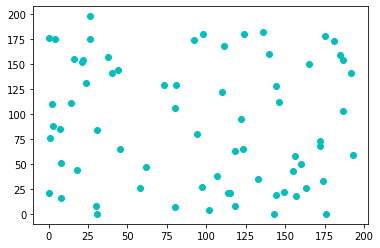

In [12]:
sa.animateSolutions()

###### Note:  Maybe animate does'nt  display on jupyter..! for see the animate result run "Simulated Annealing Algotithm to sove Travelling Salesman Problem (TSP) in Python From Scratch.py" in IDLE or another python environment.

### Show the improvement over time

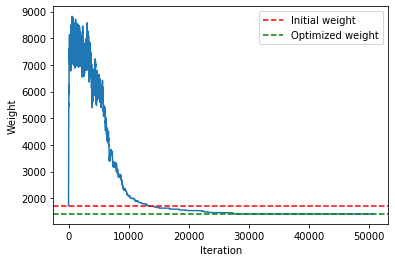

In [13]:
sa.plotLearning()